In [25]:
import matplotlib.pyplot as plt
import keras
import keras_lmu
import numpy as np
import nengo
import pandas as pd
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, roc_curve
import sys,os
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [26]:
sys.path.insert(0,'../networks')
from ldn import LDN

In [27]:
sys.path.insert(0,'../')
from utilities import generate_train_test_split
data_dir = '../fall_detection_data/merged_processed/'
subject_file = 'SA06-merged.csv'

In [28]:
# LDN parameters
size_in = 9         # 9 features of the fall detection data
theta = 1
q = 42


# load data and generate the train/test split
ddf = pd.read_csv(os.path.join(data_dir,subject_file),index_col=0).drop(['TimeStamp(s)','FrameCounter'],axis=1)
#print(ddf)

train_test_split = 0.8
chunk_size = 3600

/tmp/ipykernel_14283/1193399771.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ddf = pd.read_csv(os.path.join(data_dir,subject_file),index_col=0).drop(['TimeStamp(s)','FrameCounter'],axis=1)


In [29]:
# Extracting and preprocessing the data
chunk_indices = np.arange(0,ddf.shape[0],chunk_size)
train_chunk_indices = np.random.choice(chunk_indices,size = int(len(chunk_indices)*train_test_split), replace = False)
test_chunk_indices = list(set(chunk_indices)-set(train_chunk_indices))

train_df = pd.DataFrame(columns=ddf.columns)
for idx in train_chunk_indices:
    train_df = pd.concat([train_df,ddf.iloc[idx:idx+chunk_size,:]],axis=0)

test_df = pd.DataFrame(columns=ddf.columns)
for idx in test_chunk_indices:
    test_df = pd.concat([test_df,ddf.iloc[idx:idx+chunk_size,:]],axis=0)

train_xs = train_df[['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','EulerX','EulerY','EulerZ']].to_numpy().astype(float)
lmu_train_xs = LDN(theta=theta, q=q, size_in=size_in).apply(train_xs)
train_ys = train_df[['Fall/No Fall']].to_numpy().astype(int)

test_xs = test_df[['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','EulerX','EulerY','EulerZ']].to_numpy().astype(float)
test_ys = test_df[['Fall/No Fall']].to_numpy().astype(int)

In [30]:
num_classes = len(np.unique(train_ys))
train_xs = train_xs.reshape((train_xs.shape[0], train_xs.shape[1], 1))
test_xs = test_xs.reshape((test_xs.shape[0], test_xs.shape[1], 1))

idx = np.random.permutation(len(train_xs))
print(len(train_xs))
train_xs = train_xs[idx]
train_ys = train_ys[idx]

93861


In [33]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    #max_pool_1d = tf.keras.layers.MaxPooling1D(pool_size=2,strides=1, padding='valid')

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    #gap = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = tf.keras.layers.LSTM()(conv3)
    #output_layer = lstm(conv3)
    #output_layer = keras.layers.Dense(num_classes, activation="softmax")()

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [34]:
model = make_model(input_shape=test_xs.shape[1:])
keras.utils.plot_model(model, show_shapes=True)
epochs = 1
batch_size = 256

2023-06-16 09:13:07.167367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 09:13:07.168229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 09:13:07.168998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_lstm.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    train_xs,
    train_ys,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

2023-06-16 09:12:28.463338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 09:12:28.464215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 09:12:28.465199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

292/294 [============================>.] - ETA: 0s - loss: 0.6434 - sparse_categorical_accuracy: 0.6968

2023-06-16 09:12:32.695483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 09:12:32.696581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 09:12:32.697314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

294/294 [==============================] - 5s 11ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.6976 - val_loss: 1.1216 - val_sparse_categorical_accuracy: 0.4676 - lr: 0.0010


In [10]:
#model = keras.models.load_model("best_model.h5")

In [11]:
predict_ys = model.predict(test_xs)

110/684 [===>..........................] - ETA: 0s

2023-06-16 08:44:27.411368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 08:44:27.412454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 08:44:27.413115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

684/684 [==============================] - 1s 879us/step


In [39]:
predictions = np.argmax(predict_ys, axis = 1)
predictions_score = np.argmax(predict_ys, axis = 1) * np.max(predict_ys, axis = 1) / np.sum(predict_ys, axis=1)
print(predictions_score.shape)

(25200,)


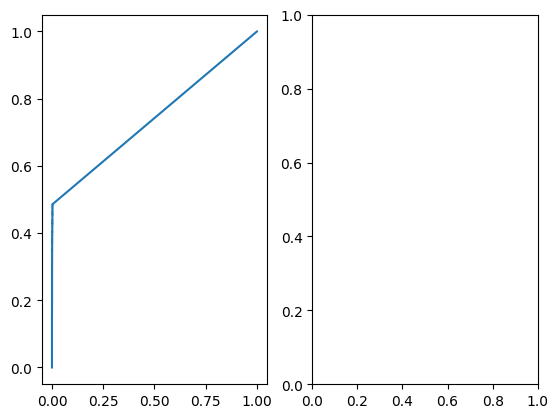

In [20]:
fig,axs = plt.subplots(1,2)
fpr,tpr,thr = roc_curve(y_true = test_ys, y_score = predictions_score,pos_label=1)
axs[0].plot(fpr,tpr)
#pre,rec,thr = precision_recall_curve(y_true = prdf['y-true'], probas_pred = prdf['y-score'], pos_label = 1)
#axs[1].plot(rec,pre)
plt.show()

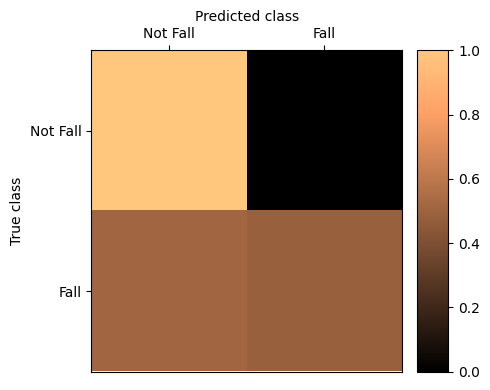

In [21]:
CM = confusion_matrix(test_ys,predictions,normalize='true')
accuracy_metrics = CM.ravel()

TN = accuracy_metrics[0]
FP = accuracy_metrics[1]
FN = accuracy_metrics[2]
TP = accuracy_metrics[3]

fig,(ax,cax) = plt.subplots(1,2,figsize=(5,4),gridspec_kw={'width_ratios':[10,1]})
im = ax.imshow(CM,vmin=0.,vmax=1.,cmap = 'copper',aspect='auto')
    
ax.set_xticks([0,1])
ax.set_xticklabels(['Not Fall','Fall'])
ax.set_xlabel('Predicted class')
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_label_position('top')
    
ax.set_yticks([0,1])
ax.set_yticklabels(['Not Fall','Fall'])
ax.set_ylabel('True class')
    
cbar = fig.colorbar(im, cax = cax)
    
fig.tight_layout()
plt.show()

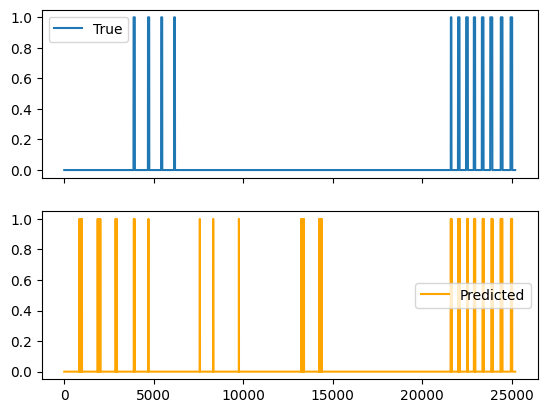

In [22]:
time = np.arange(test_xs.shape[0])
#tn, fp, fn, tp = confusion_matrix(test_ys.flatten(), np.amax(predictions.flatten(), axis=0).ravel())

# performance_metric, number in zip(('True Negatives','False Positives','False Negatives','True Positives'),(tn, fp, fn, tp)):
 #   print('{}: {}'.format(performance_metric,number))
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
time = np.arange(len(test_xs))
ax1.plot(time, test_ys.flatten(), label='True')
#ax2.plot(time, [p_category]/scaling_factor, label='Predicted')
ax2.plot(time, predictions.flatten(), color="orange", label = 'Predicted')
ax1.legend()
ax2.legend()
plt.show()